# Importing Data

## Loading the preprocessed medquad data

In [4]:
# load medQuad preprocessed dataset
import json

# Open the JSON file
with open("train.json", 'r') as f:
    # Load the contents of the file into a variable
    json_data = f.read()

# Parse the JSON data into a Python dictionary
dataset_raw = json.loads(json_data)

In [5]:
print(type(dataset_raw))

<class 'dict'>


In [6]:
dataset_raw.keys

<function dict.keys>

In [7]:
types = set()
for k in dataset_raw:
  for qa in range(len(dataset_raw[k]["QAs"])):
    types.add(str(dataset_raw[k]["QAs"][qa]["type"]))

In [8]:
types

{'causes',
 'complications',
 'considerations',
 'exams and tests',
 'frequency',
 'genetic changes',
 'information',
 'inheritance',
 'outlook',
 'prevention',
 'research',
 'stages',
 'support groups',
 'susceptibility',
 'symptoms',
 'treatment'}

## Creating a questions dataframe (lookup table)... (Learned from prev mistake, train set has repeatations that get deleted once you do dictionary lmfao)

In [9]:
import pandas as pd
import warnings
from tqdm.notebook import tqdm
df = pd.DataFrame(columns=['types', 'questions', 'answers'])
for k in tqdm(dataset_raw):
  for qa in range(len(dataset_raw[k]["QAs"])):    
    typee = str(dataset_raw[k]["QAs"][qa]["type"])
    question = str(dataset_raw[k]["QAs"][qa]["question"])
    answer = str(dataset_raw[k]["QAs"][qa]["answer"])
    
    # Create a new DataFrame row with the extracted values
    new_row = pd.DataFrame([[typee, question, answer]], columns=['types', 'questions', 'answers'])
    
    # Append the new row to the existing DataFrame
    

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        df = df.append(new_row, ignore_index=True)

  0%|          | 0/5492 [00:00<?, ?it/s]

In [10]:
df.head()

,types,questions,answers
0,information,What is (are) Breast Cancer ?,How Tumors Form The body is made up of many ty...
1,susceptibility,Who is at risk for Breast Cancer? ?,Some women develop breast cancer and others do...
2,susceptibility,Who is at risk for Breast Cancer? ?,What Is Cancer Prevention? Cancer prevention i...
3,exams and tests,How to diagnose Breast Cancer ?,"Most cancers in their early, most treatable st..."
4,treatment,What are the treatments for Breast Cancer ?,There are many treatment options for women wit...


## Visualizing the question Types

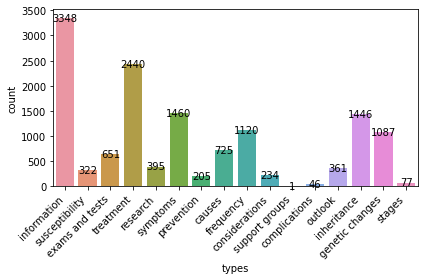

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the categorical column is named 'category'
sns.countplot(data=df, x='types')

for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')
    
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees
plt.tight_layout()  # Adjust the spacing to prevent label overlapping
plt.show()

In [12]:
# df.to_csv('medquad_type_q_a.csv', index=False)

In [13]:
# !pip install InstructorEmbedding
# !pip install sentence_transformers

# Embedding Starts

In [14]:
from InstructorEmbedding import INSTRUCTOR

## Load the instructOR embeddor model

In [15]:
model = INSTRUCTOR('hkunlp/instructor-large')

load INSTRUCTOR_Transformer
max_seq_length  512


In [16]:
# question = list(questions.keys())

In [17]:
import numpy as np

def make_inst_ques(instruction, question):
    return [instruction, question]

## Preprocessing

In [18]:
# Apply the make_inst_ques function on the 'questions' column
df['instruction_question'] = df['questions'].apply(lambda x: make_inst_ques("Represent the Medicine sentence for retrieval: ", x))

In [19]:
df["instruction_question"][0]

['Represent the Medicine sentence for retrieval: ',
 'What is (are) Breast Cancer ?']

## Performing the embedding depending on the question type on train set

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

embeddingWRTgroup = {}

# Group the DataFrame by the 'category' column
grouped = df.groupby('types')

# Loop over each group
for category, group in tqdm(grouped):
    print("Embedding", category)
    inst_ques_train = group["instruction_question"].values.tolist()
    
    embeddingWRTgroup[category] = model.encode(inst_ques_train)  # Embedding the corpus

  0%|          | 0/16 [00:00<?, ?it/s]

Embedding causes
Embedding complications
Embedding considerations
Embedding exams and tests
Embedding frequency
Embedding genetic changes
Embedding information
Embedding inheritance
Embedding outlook
Embedding prevention
Embedding research
Embedding stages
Embedding support groups
Embedding susceptibility
Embedding symptoms
Embedding treatment


# Testing on GPT

## Reading csv which already has inferred question types using a BERT classifier

In [22]:
df_test = pd.read_csv("test_100_with_pred.csv")

## Preprocessing

In [23]:
df_test['instruction_question'] = df_test['questions'].apply(lambda x: make_inst_ques("Represent the Medicine sentence for retrieval: ", x))

## Get Top-k similarities

In [24]:
def get_top_k_similarities(similarities, k):
    top_k_indices = np.argsort(similarities, axis=1)[:, -k:][:, ::-1]
    return top_k_indices

## Openai API

In [26]:
import openai

# Set your OpenAI API key
openai.api_key = 'ENTER_YOUR_API_KEY_HERE'

def answer_question_dynamic(prompt):
    response = openai.Completion.create(
        engine="davinci",
        prompt=prompt,
        max_tokens=300,
        temperature=0.5,
        n=1,
        stop=None
    )
    rephrased_sentence = response.choices[0].text.strip().split('\n')[0]
    return rephrased_sentence

## Dynamic Prompting: Do the inference using cosine similarity depending on the qtype

In [27]:
import torch
prompt = "Imagine that you are a expert medical professional. You are in a clinic and patients asks you medical questions.\nThe topics for the questions could include Treatment, Diagnosis, Side Effects associated with diseases, drugs and other medical entities such as tests.\nYour job is to answer them not more than 300 words, in simple yet, informative language.\nLet's start:"
s_prompt = "\n\nSimilarly, answer the following question: -"
CUTOFF = 300

predicted_answers = []
for index, row in tqdm(df_test.iterrows()):
    # Accessing values of each row
    test = row["questions"]
    inst_ques_test = [row["instruction_question"]]
    query_embedding = model.encode(inst_ques_test)
    
    typee = row["pred_types"]
    
    similarities = cosine_similarity(query_embedding, embeddingWRTgroup[typee])
    
    top_k_simi = get_top_k_similarities(similarities, k=2)
    
    group_type = grouped.get_group(typee)
    train = ""
    c = 0
    for k, ind in enumerate(top_k_simi[0]):
        row_grp = group_type.iloc[ind]
#         print(row_grp['answers'].values)
        
        train += f"\n\nQuestion {k+1}. {row_grp['questions']}"  # Add the question
        train += f"\nAnswer: {(' '.join(row_grp['answers'].split(' ')[:CUTOFF]) )}" # Add the answer
        c = k+1
    test = f"\nQuestion {c+1}. {test}" + "\nAnswer: "
    final = prompt + train + s_prompt + test
    
#     print(final)
    
    answer = answer_question_dynamic(final)

    predicted_answers.append(answer)
    
torch.save(predicted_answers, "pred_answers100_DP_TopicWise.pth")

0it [00:00, ?it/s]

In [28]:
predicted_answers[:10]

['What are the signs and symptoms of Normal pressure hydrocephalus? Normal pressure hydrocephalus is a condition that results in the accumulation of cerebrospinal fluid (CSF) in the brain. The signs and symptoms of normal pressure hydrocephalus include: Headache Dementia Urinary incontinence',
 'Skin blushing is a common problem, affecting around 80% of people at some time in their lives. It can be triggered by a wide range of situations, including: Embarrassment, anger, fear, and sexual situations.',
 'Pneumococcal infections are caused by bacteria called pneumococci. These bacteria can cause infections in the lungs, ears, sinuses, and other parts of the body. ',
 'Breathing difficulty (also called shortness of breath, breathlessness, or dyspnea) is usually due to a problem with the lungs, heart, or blood vessels.',
 'Celiac disease (also called sprue, nontropical sprue, and gluten intolerance) is a disorder of the small intestine that occurs in genetically predisposed people of all a

In [ ]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import  word_tokenize
import numpy as np
from rouge import Rouge

# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

rouge = Rouge()

# pred_caption = word_tokenize(pred_caption.lower())

ground_truth = df_test["answers"].values.tolist()
generated_ans = predicted_answers

Bleu1 = []
Bleu4 = []
rouge_1_score = []
rouge_2_score = []
rouge_L_score = []

for i in range(len(ground_truth)):
    grndAns = ground_truth[i]
    gen_ans = generated_ans[i]
    
    # BLEU SCORES
    gen_ans_ = word_tokenize(gen_ans.lower())
    grndAns_ = word_tokenize(grndAns.lower())
    bleu1_ = bleu1(grndAns_, gen_ans_)
    bleu4_ = bleu4(grndAns_, gen_ans_)
    Bleu1.append(bleu1_)
    Bleu4.append(bleu4_)
    
    # Rouge
    scores = rouge.get_scores(gen_ans, grndAns)
    r1s = scores[0]['rouge-1']['f'] # f1 score
    r2s = scores[0]['rouge-2']['f']
    rLs = scores[0]['rouge-l']['f']
    rouge_1_score.append(r1s)
    rouge_2_score.append(r2s)
    rouge_L_score.append(rLs)
    

print("BLEU 1 Gram: ", np.mean(Bleu1))
print("BLEU 4 Gram: ", np.mean(Bleu4))
print("ROUGE 1 Gram:", np.mean(rouge_1_score))
print("ROUGE 2 Gram:", np.mean(rouge_2_score))
print("ROUGE L Gram:", np.mean(rouge_L_score))


# dick = {
# "BLEU 1 Gram: ": np.mean(Bleu1),
# "BLEU 4 Gram: ": np.mean(Bleu4),
# "ROUGE 1 Gram:": np.mean(rouge_1_score),
# "ROUGE 2 Gram:": np.mean(rouge_2_score),
# "ROUGE L Gram:": np.mean(rouge_L_score),
# "predictions": pred_answers
# }

# torch.save(dick, 'resultsBG.pth')

## Reading csv which already has inferred question types using a BERT classifier

In [ ]:
df_test = pd.read_csv("test_100_with_pred.csv")

## Preprocessing

In [ ]:
df_test['instruction_question'] = df_test['questions'].apply(lambda x: make_inst_ques("Represent the Medicine sentence for retrieval: ", x))

## Get Top-k similarities

In [ ]:
def get_top_k_similarities(similarities, k):
    top_k_indices = np.argsort(similarities, axis=1)[:, -k:][:, ::-1]
    return top_k_indices

## Openai API

In [ ]:
import openai

# Set your OpenAI API key
openai.api_key = 'ENTER_YOUR_API_KEY_HERE'

def answer_question_dynamic(prompt):
    response = openai.Completion.create(
        engine="davinci",
        prompt=prompt,
        max_tokens=300,
        temperature=0.5,
        n=1,
        stop=None
    )
    rephrased_sentence = response.choices[0].text.strip().split('\n')[0]
    return rephrased_sentence

## Dynamic Prompting: Do the inference using cosine similarity depending on the qtype

In [ ]:
import torch
prompt = "Imagine that you are a expert medical professional. You are in a clinic and patients asks you medical questions.\nThe topics for the questions could include Treatment, Diagnosis, Side Effects associated with diseases, drugs and other medical entities such as tests.\nYour job is to answer them not more than 300 words, in simple yet, informative language.\nLet's start:"
s_prompt = "\n\nSimilarly, answer the following question: -"
CUTOFF = 300

predicted_answers = []
for index, row in tqdm(df_test.iterrows()):
    # Accessing values of each row
    test = row["questions"]
    inst_ques_test = [row["instruction_question"]]
    query_embedding = model.encode(inst_ques_test)
    
    typee = row["pred_types"]
    
    similarities = cosine_similarity(query_embedding, embeddingWRTgroup[typee])
    
    top_k_simi = get_top_k_similarities(similarities, k=2)
    
    group_type = grouped.get_group(typee)
    train = ""
    c = 0
    for k, ind in enumerate(top_k_simi[0]):
        row_grp = group_type.iloc[ind]
#         print(row_grp['answers'].values)
        
        train += f"\n\nQuestion {k+1}. {row_grp['questions']}"  # Add the question
        train += f"\nAnswer: {(' '.join(row_grp['answers'].split(' ')[:CUTOFF]) )}" # Add the answer
        c = k+1
    test = f"\nQuestion {c+1}. {test}" + "\nAnswer: "
    final = prompt + train + s_prompt + test
    
#     print(final)
    
    answer = answer_question_dynamic(final)

    predicted_answers.append(answer)
    
torch.save(predicted_answers, "pred_answers100_DP_TopicWise.pth")

0it [00:00, ?it/s]

In [ ]:
predicted_answers[:10]

['What are the signs and symptoms of Normal pressure hydrocephalus? Normal pressure hydrocephalus is a condition that results in the accumulation of cerebrospinal fluid (CSF) in the brain. The signs and symptoms of normal pressure hydrocephalus include: Headache Dementia Urinary incontinence',
 'Skin blushing is a common problem, affecting around 80% of people at some time in their lives. It can be triggered by a wide range of situations, including: Embarrassment, anger, fear, and sexual situations.',
 'Pneumococcal infections are caused by bacteria called pneumococci. These bacteria can cause infections in the lungs, ears, sinuses, and other parts of the body. ',
 'Breathing difficulty (also called shortness of breath, breathlessness, or dyspnea) is usually due to a problem with the lungs, heart, or blood vessels.',
 'Celiac disease (also called sprue, nontropical sprue, and gluten intolerance) is a disorder of the small intestine that occurs in genetically predisposed people of all a

In [ ]:

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import  word_tokenize
import numpy as np
from rouge import Rouge

# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

rouge = Rouge()

# pred_caption = word_tokenize(pred_caption.lower())

ground_truth = df_test["answers"].values.tolist()
generated_ans = predicted_answers

Bleu1 = []
Bleu4 = []
rouge_1_score = []
rouge_2_score = []
rouge_L_score = []

for i in range(len(ground_truth)):
    grndAns = ground_truth[i]
    gen_ans = generated_ans[i]
    
    # BLEU SCORES
    gen_ans_ = word_tokenize(gen_ans.lower())
    grndAns_ = word_tokenize(grndAns.lower())
    bleu1_ = bleu1(grndAns_, gen_ans_)
    bleu4_ = bleu4(grndAns_, gen_ans_)
    Bleu1.append(bleu1_)
    Bleu4.append(bleu4_)
    
    # Rouge
    scores = rouge.get_scores(gen_ans, grndAns)
    r1s = scores[0]['rouge-1']['f'] # f1 score
    r2s = scores[0]['rouge-2']['f']
    rLs = scores[0]['rouge-l']['f']
    rouge_1_score.append(r1s)
    rouge_2_score.append(r2s)
    rouge_L_score.append(rLs)
    

print("BLEU 1 Gram: ", np.mean(Bleu1))
print("BLEU 4 Gram: ", np.mean(Bleu4))
print("ROUGE 1 Gram:", np.mean(rouge_1_score))
print("ROUGE 2 Gram:", np.mean(rouge_2_score))
print("ROUGE L Gram:", np.mean(rouge_L_score))


# dick = {
# "BLEU 1 Gram: ": np.mean(Bleu1),
# "BLEU 4 Gram: ": np.mean(Bleu4),
# "ROUGE 1 Gram:": np.mean(rouge_1_score),
# "ROUGE 2 Gram:": np.mean(rouge_2_score),
# "ROUGE L Gram:": np.mean(rouge_L_score),
# "predictions": pred_answers
# }

# torch.save(dick, 'resultsBG.pth')